In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from math import sqrt, exp, factorial
import pprint
from scipy.stats import norm


In [2]:
def range_(start=0, end=1, factor=1, step=1):
    return [i * factor for i in range(start, end, step)]


def bicoef(top, bottom):
    return factorial(top) / (factorial(bottom) * factorial(top - bottom))


In [3]:
class Option:
    def __init__(
        self,
        S0,
        sigma,
        number_of_periods,
        Time_horizon,
        strike_prices,
        log_variation=None,
        interest_rate=None,
        deltaT=None,
        h=0,
    ):
        self.S = {"": "", 0: S0}
        self.v = log_variation or interest_rate - 1 / 2 * sigma**2
        self.sigma = sigma
        self.number_of_periods = number_of_periods
        self.deltaT = deltaT or (1 / self.number_of_periods)
        self.T = Time_horizon
        self.K = strike_prices
        self.excercise_matrixCall = {}
        self.excercise_matrixPut = {}
        self.C = {}
        self.P = {}
        self.probCall = 0
        self.probPut = 0
        self.h = h
        self.r = interest_rate or self.v + 1 / 2 * self.sigma**2
        self.get_values()

    def get_values(self):
        self.R = exp(self.r * (self.deltaT))
        self.u = exp(self.sigma * sqrt(self.deltaT))
        self.d = 1 / self.u
        self.p = 1 / 2 + 1 / 2 * self.v / self.sigma * sqrt(self.deltaT)
        self.q = (self.R - self.d) / (self.u - self.d)

    def binomialMap(self, show=True):
        for j in range_(-self.number_of_periods, 1, -1):
            for i in range(0, j + 1):
                self.S["U" * i + "D" * (j - i) + "S0"] = max(
                    0, (self.S[0] * (self.u**i) * (self.d ** (j - i)))
                )
        """initial RHS of the C tree"""
        for i in range_(0, self.number_of_periods + 1):
            self.C["U" * i + "D" * (self.number_of_periods - i) + "S0"] = max(
                0,
                (self.S["U" * i + "D" * (self.number_of_periods - i) + "S0"] - self.K),
            )
            self.P["U" * i + "D" * (self.number_of_periods - i) + "S0"] = max(
                0,
                (self.K - self.S["U" * i + "D" * (self.number_of_periods - i) + "S0"]),
            )
        """Calculate the rest of the C and P tree"""
        for j in range_(-self.number_of_periods + 1, 1, -1):
            for i in range_(0, j + 1):
                self.C["U" * i + "D" * (j - i) + "S0"] = (
                    1
                    / self.R
                    * (
                        self.q * self.C["U" * (i) + "U" + "D" * (j - i) + "S0"]
                        + (1 - self.q) * self.C["U" * (i) + "D" * (j - i) + "D" + "S0"]
                    )
                )
                self.P["U" * i + "D" * (j - i) + "S0"] = (
                    1
                    / self.R
                    * (
                        self.q * self.P["U" * (i) + "U" + "D" * (j - i) + "S0"]
                        + (1 - self.q) * self.P["U" * (i) + "D" * (j - i) + "D" + "S0"]
                    )
                )
        """making the excersice matrix for american option"""
        for j in range_(-self.number_of_periods, 1, -1):
            for i in range_(0, j + 1):
                if (
                    self.C["U" * i + "D" * (j - i) + "S0"]
                    <= self.S["U" * i + "D" * (j - i) + "S0"] - self.K
                ):
                    self.excercise_matrixCall[
                        "U" * i + "D" * (j - i) + "S0"
                    ] = "excercise"
                else:
                    self.excercise_matrixCall[
                        "U" * i + "D" * (j - i) + "S0"
                    ] = "not excercise"
                if (
                    self.P["U" * i + "D" * (j - i) + "S0"]
                    >= self.S["U" * i + "D" * (j - i) + "S0"] - self.K
                ):
                    self.excercise_matrixPut[
                        "U" * i + "D" * (j - i) + "S0"
                    ] = "excercise"
                else:
                    self.excercise_matrixPut[
                        "U" * i + "D" * (j - i) + "S0"
                    ] = "not excercise"
        for i in range_(-self.number_of_periods, 0, -1):
            if (
                self.excercise_matrixCall[
                    "U" * i + "D" * (self.number_of_periods - i) + "S0"
                ]
                == "excercise"
            ):
                self.probCall += (
                    self.p**i
                    * (1 - self.p) ** (self.number_of_periods - i)
                    * bicoef(self.number_of_periods, i)
                )
            if (
                self.excercise_matrixPut[
                    "U" * i + "D" * (self.number_of_periods - i) + "S0"
                ]
                == "excercise"
            ):
                self.probPut += (
                    self.p**i
                    * (1 - self.p) ** (self.number_of_periods - i)
                    * bicoef(self.number_of_periods, i)
                )
        if show:
            dic = {}
            for k in self.C.keys():
                dic[k] = [self.C[k], self.P[k], self.S[k], self.excercise_matrixCall[k]]
            print(
                pd.DataFrame(
                    (dic.values()), index=dic.keys(), columns=["C", "P", "S", "Option"]
                ).tail()
            )
            return "call probability", self.probCall, "put probability", self.probPut
        else:
            return (
                self.S,
                self.C,
                self.P,
                self.excercise_matrixCall,
                self.excercise_matrixPut,
            )

    def Black_Scholes(self):
        self.D1 = (
            1
            / (self.sigma * sqrt(self.T))
            * (
                np.log(self.S[0] / self.K)
                + ((self.r - self.h + self.sigma**2 / 2) * (self.T))
            )
        )
        self.D2 = (
            1
            / (self.sigma * sqrt(self.T))
            * (
                np.log(self.S[0] / self.K)
                + ((self.r - self.h - self.sigma**2 / 2) * (self.T))
            )
        )
        # you might need to add smal t to the equation here
        self.call_price = norm.cdf(self.D1) * self.S[0] * exp(
            -self.h * (self.T)
        ) - norm.cdf(self.D2) * self.K * exp(-self.r * (self.T))
        self.put_price = self.call_price - self.S[0] + self.K * exp(-self.r * self.T)

        return (
            "Call prize is "
            + str(self.call_price)
            + " w.p. "
            + str(norm.cdf(self.D2))
            + "\nPut prize is "
            + str(self.put_price)
            + " w.p. "
            + str(1 - norm.cdf(self.D2))
        )

    def greeks_call(self, show=False):
        """returns --> deltaCall, thetaCall, gammaCall, vegaCall"""
        self.Black_Scholes()
        self.deltaCall = norm.cdf(self.D1)
        self.thetaCall = (self.S[0] * norm.cdf(self.D1) * self.sigma) / (
            2 * sqrt(T)
        ) - r * self.K * exp(-self.r * self.T * norm.cdf(self.D2))
        self.gammaCall = norm.cdf(self.D1) / (self.S[0] * self.sigma * sqrt(T))
        self.vegaCall = self.S[0] * sqrt(T) * self.sigma * norm.cdf(self.D1)
        self.rho = self.K*self.T*exp(-self.r*self.T)*norm.cdf(self.D2)
        if show:
            print(
                f"Delta = {self.deltaCall},\nTheta = {self.thetaCall},\nGamma = {self.gammaCall},\nVega = {self.vegaCall},\nRho = {self.rho}"
            )
        return self.deltaCall, self.thetaCall, self.gammaCall, self.vegaCall,self.rho

    def make_binomial_tree(self):
        self.binomialMap(False)
        self.columns = {}
        self.columns2 = {}
        if self.number_of_periods < 4:
            self.st = """\\documentclass{article}
    \\usepackage{tikz}
    \\usetikzlibrary{matrix}
    \\usepackage{lscape}
    \\begin{document}
    \\begin{landscape}
    \\begin{tikzpicture}[>=stealth,sloped]
                        \\matrix (tree) [%
                        matrix of nodes,
                        minimum size=1cm,
                        column sep=3.5cm,
                        row sep=1cm,
                        ]
                    {"""
        else:
            self.st = """\\documentclass{article}
    \\usepackage{tikz}
    \\usetikzlibrary{matrix}
    \\usepackage{lscape}
    \\begin{document}
    \\begin{landscape}
    \\begin{tikzpicture}[>=stealth,sloped]
                        \\matrix (tree) [%
                        matrix of nodes,minimum size=0.5cm,
                    column sep=1cm,
                    row sep=0.5cm,]{"""
        self.st2 = ""
        for j in range_(-self.number_of_periods, 1, -1):
            for i in range_(0, j + 1):
                pass
        l = self.number_of_periods + 1
        for k in self.C.keys():
            i = k.count("U")
            j = k.count("D")
            try:
                self.columns[i + j].append("")
                self.columns2[i + j].append("")
            except:
                self.columns[i + j] = [
                    "" for l in range(self.number_of_periods - j - i)
                ]
                self.columns2[i + j] = [
                    "" for l in range(self.number_of_periods - j - i)
                ]
            self.columns2[i + j].append(self.C[k])
            self.columns[i + j].append(
                "U" * i + "D" * j + ("S0" if (j + i >= 0) else "")
            )
        self.C[""] = ""
        self.P[""] = ""
        for k in self.C.keys():
            i = k.count("U")
            j = k.count("D")
            for l in range(self.number_of_periods - j - i):
                self.columns[i + j].append("")
                self.columns2[i + j].append("")
        for i in range_(-2 * self.number_of_periods, 1, -1):
            for j in range(len(self.columns)):
                if j != len(self.columns) - 1:
                    try:
                        SSS = str(round(self.S[self.columns[j][i]], 3)) + "\\\\"
                        CCC = str(round(self.C[self.columns[j][i]], 3)) + "\\\\"
                        PPP = str(round(self.P[self.columns[j][i]], 3)) + "\\\\"
                        self.st += (
                            "\\begin{tabular}{ |c| } \n \hline\n"
                            + SSS
                            + CCC
                            + PPP
                            + "\\hline\\end{tabular} & "
                        )
                    except:
                        # print(self.columns[j][i])
                        self.st += self.columns[j][i] + " & "
                    if self.columns[j][i] != "":
                        U1, D1, U2, D2 = (
                            self.columns[j + 1][i - 1].count("D"),
                            self.columns[j + 1][i - 1].count("U"),
                            self.columns[j + 1][i + 1].count("D"),
                            self.columns[j + 1][i + 1].count("U"),
                        )
                        # adding the ligns and their values between nodes on the tree
                        self.st2 += (
                            (
                                f"\draw[->] (tree-{i+1}-{j+1}) -- (tree-{i}-{j+2}) node [midway,above] "
                            )
                            + f'{"{"}$ {"p" if U1 ==1 else f"p^{U1}" if U1 > 0 else ""} {"(1-p)" if D1 == 1 else f"(1-p)^{D1}" if D1 > 0 else ""} ${"}"};\n'
                            + (
                                f"\draw[->] (tree-{i+1}-{j+1}) -- (tree-{i+2}-{j+2}) node [midway,above] "
                            )
                            + f'{"{"}$ {"p" if U2 ==1 else f"p^{U2}" if U2 > 0 else ""} {"(1-p)" if D2 == 1 else f"(1-p)^{D2}" if D2 > 0 else ""} ${"}"};\n'
                        )
                else:
                    try:
                        SSS = str(round(self.S[self.columns[j][i]], 3)) + "\\\\"
                        CCC = str(round(self.C[self.columns[j][i]], 3)) + "\\\\"
                        PPP = str(round(self.P[self.columns[j][i]], 3)) + "\\\\"
                        self.st += (
                            "\\begin{tabular}{ |c| } \n \hline\n"
                            + SSS
                            + CCC
                            + PPP
                            + "\\hline\\end{tabular} & "
                        )
                    except:
                        self.st += self.columns[j][i] + " & "

            self.st += " \\\\\n"
        self.st += (
            "};\n" + self.st2 + "\end{tikzpicture}\n\end{landscape}\n\end{document}"
        )
        return self.st

    @property
    def BS(self):
        return self.Black_Scholes()


In [4]:
sigma = sqrt(1 / 66)
number_of_periods = 2
deltaT = 0
T = 1
K = 38
S = 39
r = 1 / 100
v = r - 1 / 2 * sigma**2
op = Option(S, sigma, v, number_of_periods, T, K, r, h=0)
# op.make_binomial_tree()
# print(op.BS)
op = Option(S, sigma, v, number_of_periods, T, K, r, h=0)
# op.make_binomial_tree()
print(op.BS)


Call prize is 38.01980132669325 w.p. 1.0
Put prize is 2.9976021664879227e-15 w.p. 0.0


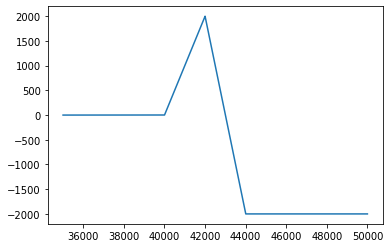

In [5]:
def P(st, k):
    return max(0, k - st)


def C(st, k):
    return max(st - k, 0)


def f(line):
    out = []
    for st in line:
        k1 = 40000
        k2 = 42000
        k3 = 44000
        out.append(C(st, k1) - 3 * C(st, k2) + 2 * C(st, k3))
    return out


line = np.linspace(35000, 50000, 10000)
plt.plot(line, f(line))
plt.show()
# f(line)


In [10]:
v = -0.133751
sigma = sqrt(0.550338)
number_of_periods = 12
T = 1
strike_prices = [40000, 42000, 44000]
S = 42600.132813
r = v +   1 / 2 * sigma**2
# v = r - 1 / 2 * sigma**2
ls = []
pb = []
w = [1,-3,2]
greeks = []
for j in strike_prices:
    # print(j)
    op = Option(S, sigma, number_of_periods, T, j,log_variation=None, interest_rate =r)
    # make_binomial_tree(3)
    # print(op.BS)
    op.BS
    ls.append(op.call_price)
    pb.append(norm.cdf(op.D2))
    greeks.append(op.greeks_call())


In [14]:
delta, theta, gamma, vega, rho = 0,0,0,0,0
# for i,v in enumerate(greeks[0]):
for j,v in enumerate(greeks):
    delta += greeks[j][0]+w[j]
    theta+= greeks[j][1]+w[j]
    gamma+= greeks[j][2]+w[j]
    vega += greeks[j][3]+w[j]
    rho += greeks[j][4]+w[j]
# pb
# K = K[0]-3*K[1]+2*K[2]
# S = float(ls[0]-3*ls[1]+2*ls[2])
# op = Option(S, sigma, number_of_periods, T, j,v, r =r)
# op.BS
# S
# pb[0]-pb[1]+pb[2]
# op.binomialMap(False)[1]
delta, theta, gamma, vega, rho

0
1
2


(2.158036568606562,
 17345.960407812658,
 6.828622362542447e-05,
 68200.02021188368,
 47654.78433593537)